In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import ast
from tqdm import tqdm  

# ===== Load CSV & Explore =====

# Path to annotation CSV
CSV_PATH = r"C:\Users\shanessa\Downloads\labels.csv" 
IMAGE_BASE_PATH = r"D:\SHANESSSA_AI_dm_zelfcheck\extracted_pictures"

print("📂 Reading CSV...")
df = pd.read_csv(CSV_PATH)
print(f"✅ Data loaded — shape: {df.shape}")

# Add progress bar when doing heavier parsing
print("🔄 Cleaning & parsing labels...")
tqdm.pandas()  # enable progress bar for pandas
def parse_foot_conditions(val):
    """
    Convert 'foot_conditions' into a list of labels.
    Handles cases like '{"choices":["Red spots..."]}' or plain strings.
    """
    if pd.isna(val):
        return []
    try:
        parsed = ast.literal_eval(val)
        if isinstance(parsed, dict) and "choices" in parsed:
            return parsed["choices"]
        elif isinstance(parsed, list):
            return parsed
        else:
            return [str(parsed)]
    except:
        return [str(val)]

df["labels"] = df["foot_conditions"].progress_apply(parse_foot_conditions)

print("Cleaning complete.")
df.head()

📂 Reading CSV...
✅ Data loaded — shape: (1490, 9)
🔄 Cleaning & parsing labels...


100%|███████████████████████████████████████████████████████████████████████████| 1490/1490 [00:00<00:00, 40168.35it/s]

Cleaning complete.


,annotation_id,annotator,created_at,foot_conditions,id,image,image_quality,lead_time,updated_at,labels
0,1338,1,2025-10-02T23:00:50.619331Z,Callus,2092,/data/upload/6/32bc2324-image_picker_813B89B4-...,Too Bright (Overexposed),63.213,2025-10-02T23:30:44.208807Z,[Callus]
1,55,1,2025-10-02T11:33:41.872893Z,Red spots on feet,2093,/data/upload/6/fa400c50-image_picker_823F45AE-...,"{""choices"":[""Blurry (out of focus)"",""Too Dark ...",34.963,2025-10-02T23:30:52.604660Z,[Red spots on feet]
2,56,1,2025-10-02T11:33:59.740515Z,Wound on foot,2094,/data/upload/6/405296a4-image_picker_832B03B2-...,Good Foot Picture,24.557,2025-10-02T23:31:01.287001Z,[Wound on foot]
3,57,1,2025-10-02T11:34:07.450818Z,Wound on foot,2095,/data/upload/6/b90c5177-image_picker_832C7F4F-...,Good Foot Picture,7.331,2025-10-02T11:34:07.450818Z,[Wound on foot]
4,58,1,2025-10-02T11:34:16.425843Z,Red spots that increase with shoes,2096,/data/upload/6/116574bb-image_picker_833BC3BA-...,Good Foot Picture,8.402,2025-10-02T11:34:16.425843Z,[Red spots that increase with shoes]


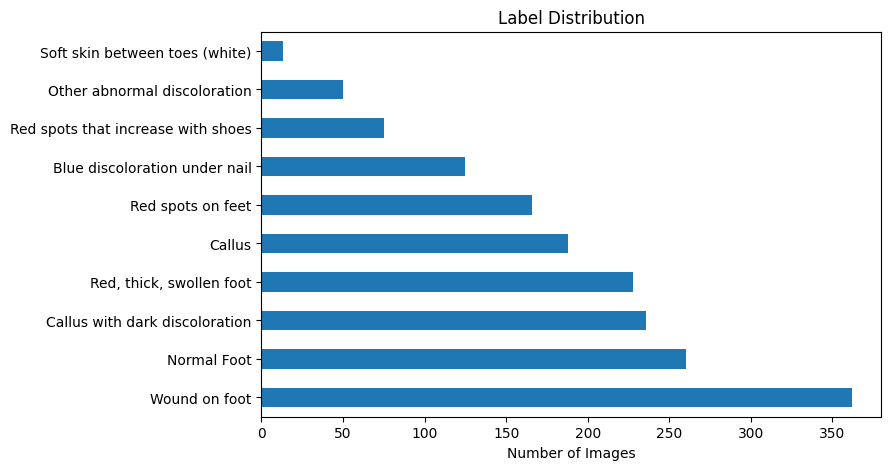

In [2]:
# ===== Clean & Normalize Label Columns =====

# foot_conditions may be JSON or string
def parse_foot_conditions(val):
    """
    Convert 'foot_conditions' into a list of labels.
    Handles cases like '{"choices":["Red spots..."]}' or plain strings.
    """
    if pd.isna(val):
        return []
    try:
        parsed = ast.literal_eval(val)
        if isinstance(parsed, dict) and "choices" in parsed:
            return parsed["choices"]
        elif isinstance(parsed, list):
            return parsed
        else:
            return [str(parsed)]
    except:
        return [str(val)]

df["labels"] = df["foot_conditions"].apply(parse_foot_conditions)

# Flatten labels to check distribution
all_labels = [label for sublist in df["labels"] for label in sublist]
label_series = pd.Series(all_labels)

label_series.value_counts().plot(kind='barh', figsize=(8,5))
plt.title("Label Distribution")
plt.xlabel("Number of Images")
plt.show()



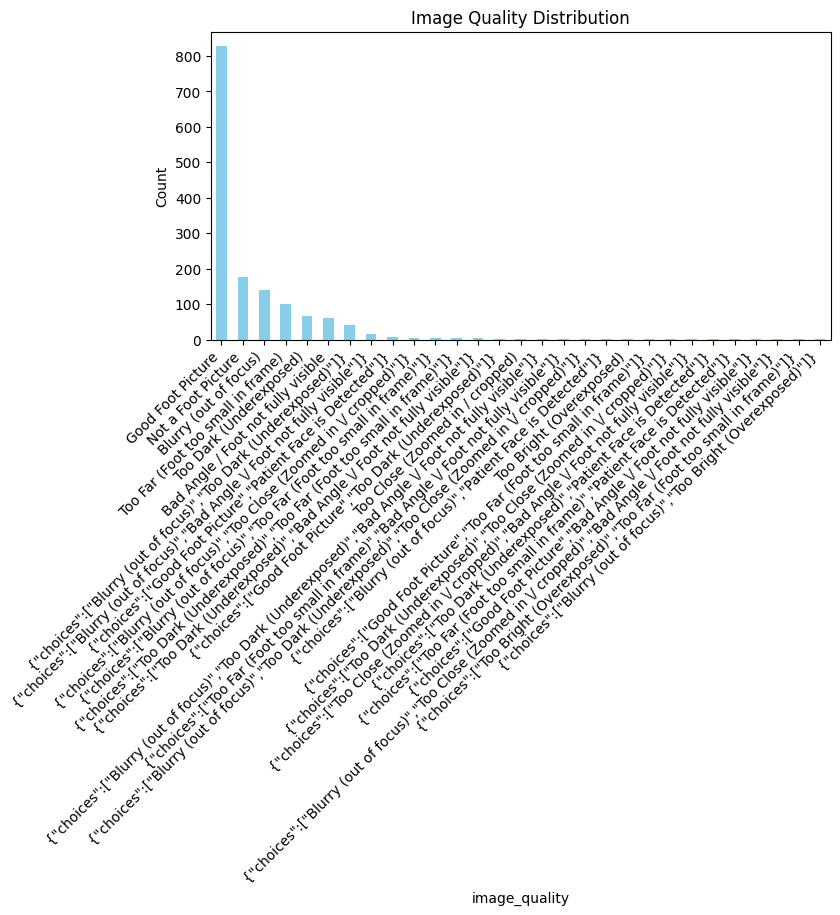

In [3]:
# ===== Visualize Image Quality =====

df["image_quality"].value_counts().plot(kind='bar', figsize=(8,4), color='skyblue')
plt.title("Image Quality Distribution")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.show()


As we can see the labeling process creates a dictonary when there are multiple labels assosiated with 1 picture. Let's first cleanup the label itself

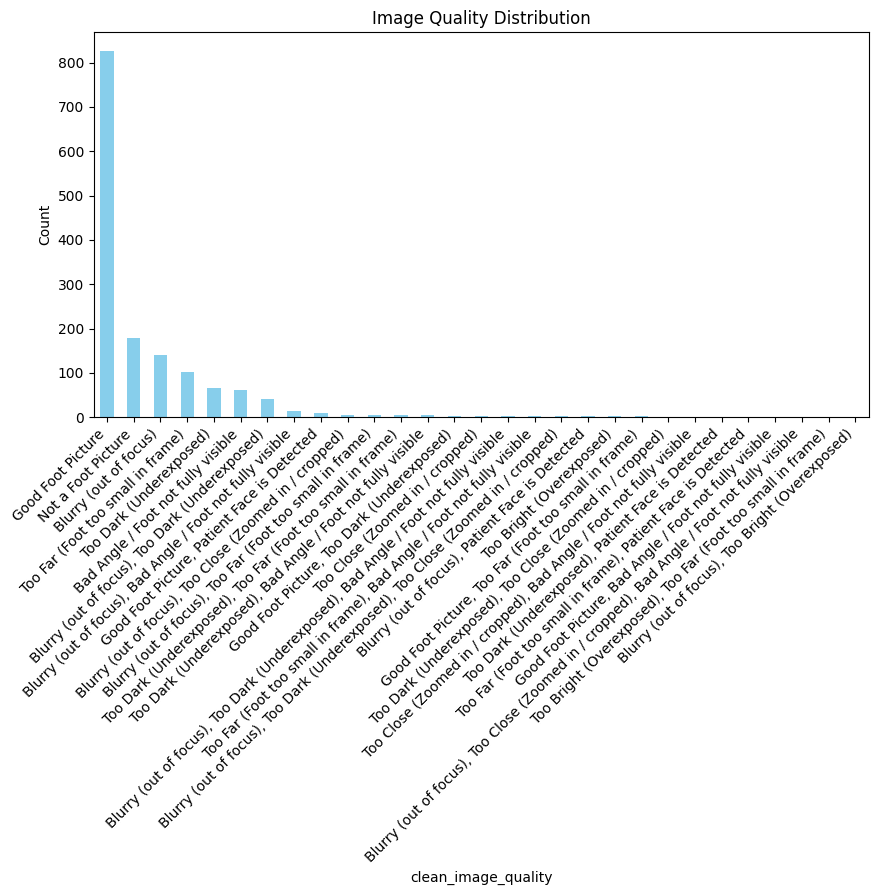

In [4]:
import json

# ===== Clean The Labels =====

def parse_image_quality(val):
    if pd.isna(val):
        return None
    if isinstance(val, str):
        try:
            parsed = json.loads(val)
            if isinstance(parsed, dict) and "choices" in parsed:
                return ", ".join(parsed["choices"])
            if isinstance(parsed, list):
                return ", ".join(parsed)
        except json.JSONDecodeError:
            return val
    return val

df["clean_image_quality"] = df["image_quality"].apply(parse_image_quality)

# Now plot
df["clean_image_quality"].value_counts().plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title("Image Quality Distribution")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.show()


Now that we have clean labels let's split the pictures so that if there is multple labels they will not be counted as a new category but it will be split and counted into it's respective category

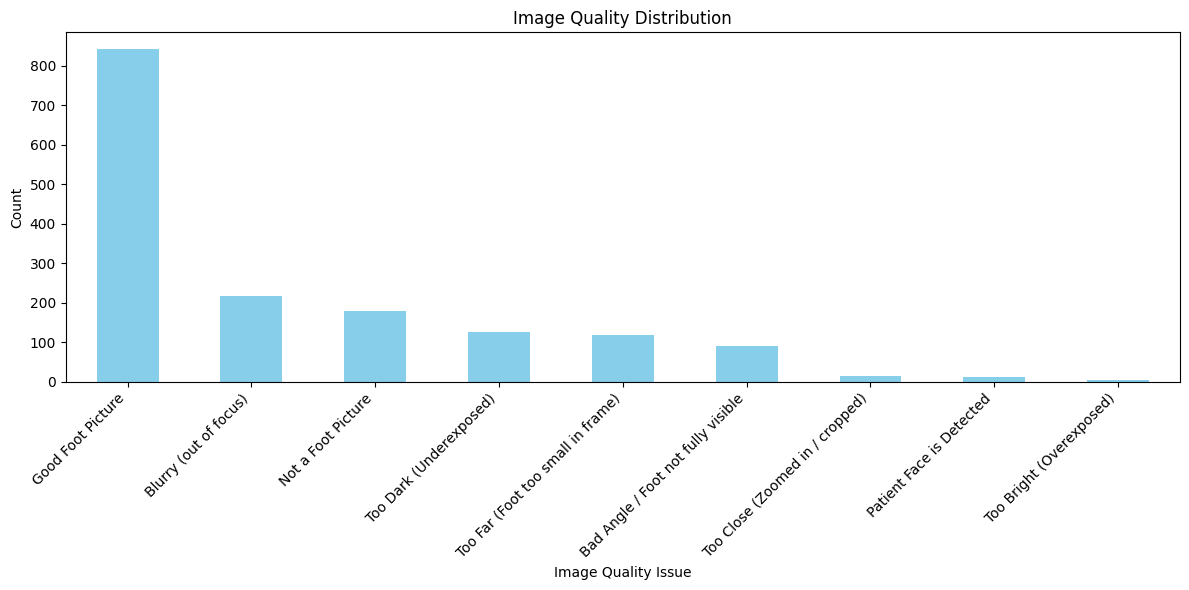

In [5]:

# ===== Clean and Parse Image Quality Labels =====

def parse_image_quality(val):
    """
    Parse the 'image_quality' field into a list of labels.
    Handles JSON strings, lists, and comma-separated text.
    """
    if pd.isna(val):
        return None

    if isinstance(val, str):
        # Try to parse JSON first
        try:
            parsed = json.loads(val)
            if isinstance(parsed, dict) and "choices" in parsed:
                return parsed["choices"]
            elif isinstance(parsed, list):
                return parsed
        except json.JSONDecodeError:
            # Not JSON, split by commas
            return [v.strip() for v in val.split(",")]
    elif isinstance(val, list):
        return val

    return [val]


# Apply the cleaning function
df["clean_image_quality"] = df["image_quality"].apply(parse_image_quality)

# Explode turns lists in cells into separate rows
df_exploded = df.explode("clean_image_quality")

# Drop any empty labels just in case
df_exploded = df_exploded.dropna(subset=["clean_image_quality"])

# Plot Distribution
plt.figure(figsize=(12,6))
df_exploded["clean_image_quality"].value_counts().plot(kind='bar', color='skyblue')

plt.title("Image Quality Distribution")
plt.xlabel("Image Quality Issue")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


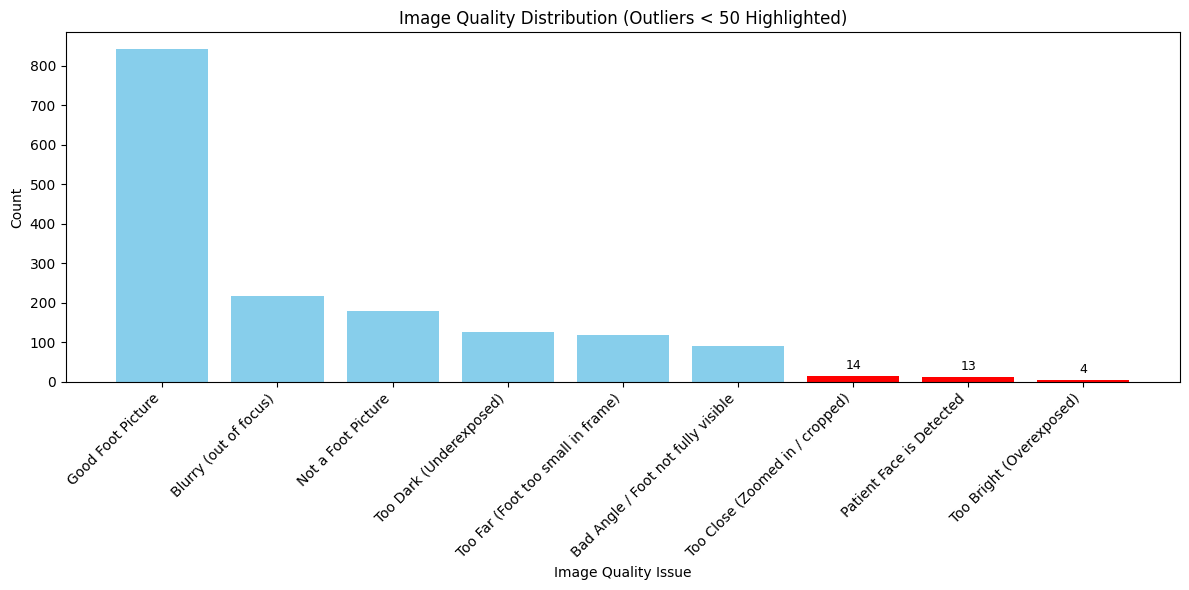

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Assuming df_exploded is already defined and cleaned ---
# 1. Get the data for plotting
data = df_exploded["clean_image_quality"].value_counts()
categories = data.index
counts = data.values

# 2. Define the outlier count threshold
# We'll use 50 as the threshold to catch all issues well below the main clusters.
OUTLIER_THRESHOLD = 50

# 3. Define colors based on the threshold
colors = []
low_count_outliers = []
for count, category in zip(counts, categories):
    if count <= OUTLIER_THRESHOLD:
        colors.append('red')
        low_count_outliers.append((category, count))
    else:
        colors.append('skyblue')

# 4. Plot the data
plt.figure(figsize=(12, 6))
plt.bar(categories, counts, color=colors)

plt.title(f"Image Quality Distribution (Outliers < {OUTLIER_THRESHOLD} Highlighted)")
plt.xlabel("Image Quality Issue")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')

# 5. Optional: Add annotations for the low-count outliers
# This helps confirm the exact count for the tiny bars
for category, count in low_count_outliers:
    plt.annotate(
        str(count),
        xy=(category, count),
        xytext=(0, 5),  # Slight offset above the bar
        textcoords='offset points',
        ha='center',
        fontsize=9,
        color='black'
    )

plt.tight_layout()
plt.show()

⚠️ Missing images: 0 / 1490


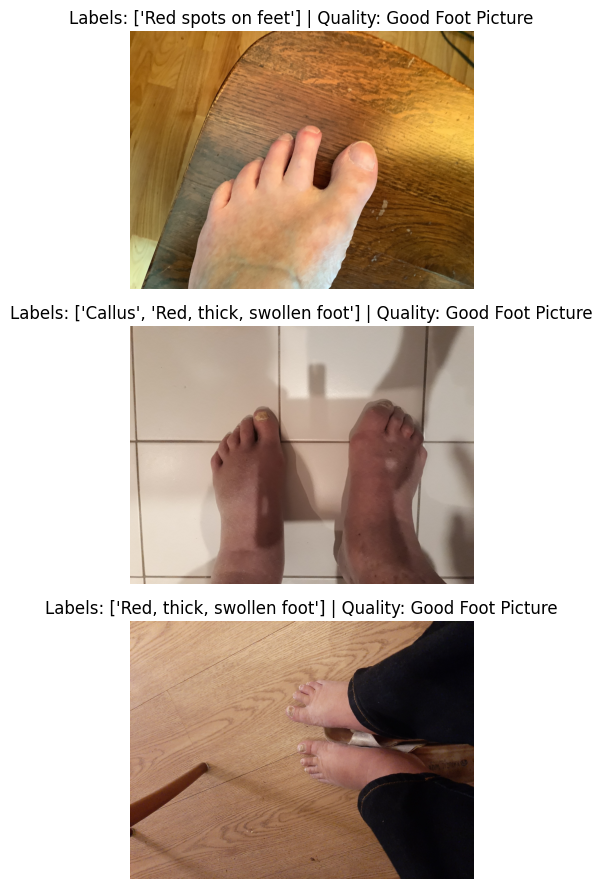

In [7]:
# Last 2 are edge case in terms of naming the file so I hardcode the names
picture_names = ["scaled_image_picker", "image_picker", "scaled", "3414e6be", "f281186a"] 

# Define image base path
IMAGE_BASE_PATH ="D:\shanessa\SHANESSSA_AI_dm_zelfcheck\extracted_pictures"

def fix_image_path(p):
    """
    Takes the CSV path and converts it into the real file path.
    """
    if pd.isna(p):
        return None
    for pName in picture_names:    
        if pName in p:
            filename = p.split(pName)[-1]
            return os.path.join(IMAGE_BASE_PATH, pName + filename)
    else:
        print(f"⚠️ Image with unexpected path format: {p}")
        return os.path.join(IMAGE_BASE_PATH, os.path.basename(p))

# Build fixed paths
df["fixed_path"] = df["image"].apply(fix_image_path)

# Check missing
missing_mask = df["fixed_path"].apply(lambda x: not os.path.exists(x))
missing_count = missing_mask.sum()
print(f"⚠️ Missing images: {missing_count} / {len(df)}")

if missing_count > 0:
    print("List of missing images:")
    for img in df.loc[missing_mask, "fixed_path"]:
        print("   ", img)

# Function to show random sample images
def show_random_samples(n=5):
    sample_rows = df.sample(min(n, len(df)))
    plt.figure(figsize=(15, 3 * n))

    for i, (_, row) in enumerate(sample_rows.iterrows()):
        img_path = row["fixed_path"]

        if img_path and os.path.exists(img_path):
            img = Image.open(img_path)
            plt.subplot(n, 1, i+1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Labels: {row['labels']} | Quality: {row['image_quality']}")
        else:
            print(f"⚠️ Image not found (sample): {img_path}")

    plt.tight_layout()
    plt.show()

show_random_samples(3)

In [8]:
# Create a dataframe with one row per image and a clean label column
# (if multi-label, we keep them as a list for now)
df_prepared = df[["image", "labels", "image_quality"]].copy()

# Optional: save cleaned data
df_prepared.to_csv("cleaned_annotations.csv", index=False)
print("Cleaned CSV saved to cleaned_annotations.csv")


Cleaned CSV saved to cleaned_annotations.csv


# Data Cleaning

In [9]:
# ===== Remove corrupted / unreadable images =====

bad_files = []
for fpath in df["fixed_path"]:
    try:
        if fpath and os.path.exists(fpath):
            img = Image.open(fpath)
            img.verify()  # validate
    except Exception:
        bad_files.append(fpath)

print(f"❌ Corrupted images: {len(bad_files)}")
if bad_files:
    print("Examples:", bad_files[:10])

# Drop corrupted images
df = df[~df["fixed_path"].isin(bad_files)]


❌ Corrupted images: 0


🧼 Cleaning, resizing, and augmenting images...


100%|██████████████████████████████████████████████████████████████████████████████| 1490/1490 [01:11<00:00, 20.71it/s]


✅ Completed cleaning — 1490 images saved to D:\shanessa\SHANESSSA_AI_dm_zelfcheck\cleaned_images


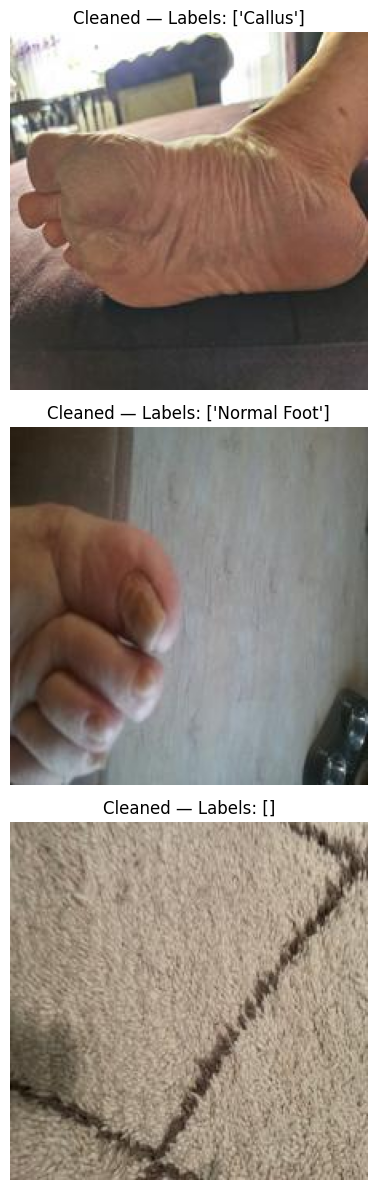

Example normalized image shape: (224, 224, 3)
Pixel range: 0.000 - 1.000


In [10]:
from PIL import ImageEnhance
import numpy as np

# ===== Image Data Cleaning & Preprocessing =====

# Output directory for cleaned/resized images
OUTPUT_DIR = r"D:\shanessa\SHANESSSA_AI_dm_zelfcheck\cleaned_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# resize for EfficientNet/ResNet
TARGET_SIZE = (224, 224)   

def clean_and_preprocess_image(src_path, dest_path):
    """
    Clean, resize, normalize, and augment images.
    """
    try:
        img = Image.open(src_path)

        # 🧩 1️⃣ Validate format — convert to RGB (3 channels)
        if img.mode != "RGB":
            img = img.convert("RGB")

        # 🔄 2️⃣ Resize to target input size
        img = img.resize(TARGET_SIZE)

        # ✨ 3️⃣ Optional: light augmentation to increase robustness
        # Random horizontal flip (50% chance)
        import random
        if random.random() > 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        # Random brightness jitter
        if random.random() > 0.7:
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(0.8, 1.2))

        # 💾 4️⃣ Save cleaned image
        img.save(dest_path)

        return True
    except Exception as e:
        print(f"⚠️ Error processing {src_path}: {e}")
        return False


# Apply cleaning to all valid images
print("🧼 Cleaning, resizing, and augmenting images...")
tqdm.pandas()

df["cleaned_path"] = df["fixed_path"].progress_apply(
    lambda p: os.path.join(OUTPUT_DIR, os.path.basename(p)) if isinstance(p, str) else None
)

df["processed"] = df.progress_apply(
    lambda row: clean_and_preprocess_image(row["fixed_path"], row["cleaned_path"])
    if isinstance(row["fixed_path"], str) and os.path.exists(row["fixed_path"])
    else False,
    axis=1
)

print(f"✅ Completed cleaning — {df['processed'].sum()} images saved to {OUTPUT_DIR}")




# ===== Verify Normalization (preview a few) =====

def preview_cleaned_images(n=3):
    sample_rows = df[df["processed"]].sample(min(n, df["processed"].sum()))
    plt.figure(figsize=(12, 4 * n))
    for i, (_, row) in enumerate(sample_rows.iterrows()):
        img = Image.open(row["cleaned_path"])
        plt.subplot(n, 1, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Cleaned — Labels: {row['labels']}")
    plt.tight_layout()
    plt.show()

preview_cleaned_images(3)



# ===== Normalize for Model Input =====

def load_and_normalize_image(img_path):
    """
    Load and convert to numpy array scaled to [0, 1].
    """
    img = Image.open(img_path).convert("RGB").resize(TARGET_SIZE)
    arr = np.array(img) / 255.0  # normalize pixel values
    return arr

# Example: load one image and check pixel range
example_img_path = df["cleaned_path"].dropna().iloc[0]
img_array = load_and_normalize_image(example_img_path)
print(f"Example normalized image shape: {img_array.shape}")
print(f"Pixel range: {img_array.min():.3f} - {img_array.max():.3f}")


✅ Environment ready
🧹 Label distribution:
clean_image_quality_simple
Good Foot Picture                     842
Blurry (out of focus)                 218
Not a Foot Picture                    178
Too Far (Foot too small in frame)     105
Too Dark (Underexposed)                77
Bad Angle / Foot not fully visible     62
Too Close (Zoomed in / cropped)         4
Too Bright (Overexposed)                3
Name: count, dtype: int64
✅ Training samples: 1191, Validation samples: 298
⚖️ Computed class weights: {0: np.float64(3.002016129032258), 1: np.float64(0.8537844036697247), 2: np.float64(0.22105106888361045), 3: np.float64(1.0456460674157304), 4: np.float64(62.041666666666664), 5: np.float64(46.53125), 6: np.float64(2.417207792207792), 7: np.float64(1.7726190476190475)}
Found 1191 validated image filenames.
Found 298 validated image filenames.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.1094 - loss: 2.2654 - val_accuracy: 0.0705 - val_loss: 1.9924
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1563 - loss: 1.8776 - val_accuracy: 0.0034 - val_loss: 2.1545
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.0733 - loss: 2.0128 - val_accuracy: 0.0705 - val_loss: 2.1025
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1256 - loss: 2.3075 - val_accuracy: 0.0436 - val_loss: 2.1450
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1126 - loss: 1.8705 - val_accuracy: 0.0705 - val_loss: 2.0894
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1250 - loss: 2.3012 - val_accuracy: 0.0403 - val_loss: 1.9978

🔧 Fine-tuning last layers of EfficientNet...
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.0207 - loss: 2.1280 - val_accuracy: 0.0705 - val_loss: 1.9794
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.0583 - l

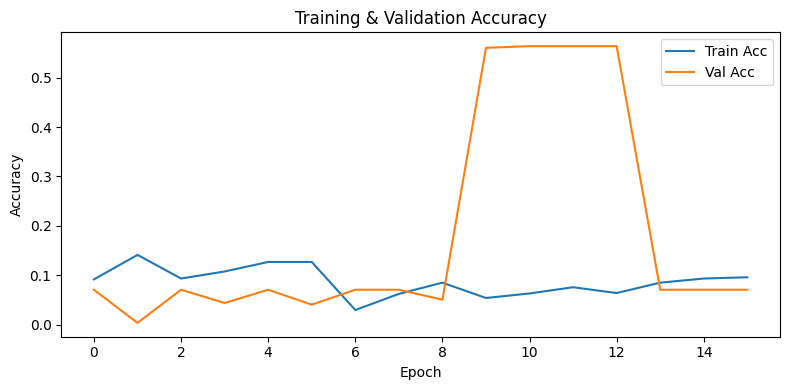

⚠️ All images used for training/validation — showing a validation example instead.

🧩 Testing unseen image: D:\shanessa\SHANESSSA_AI_dm_zelfcheck\cleaned_images\scaled_248620b1-4aff-4435-873e-cbc76a467cea7875690957875950285.JPEG
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


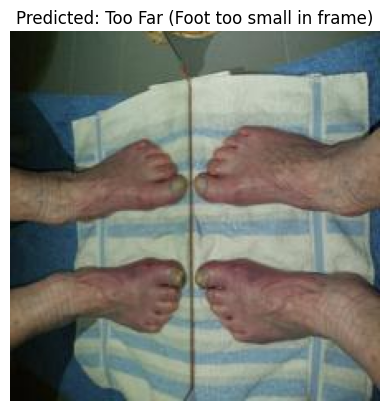

In [11]:
import warnings
warnings.filterwarnings("ignore")
import random
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing import image
import numpy as np # <-- Added numpy import
import pandas as pd # <-- Added pandas import (assuming 'df' is a pandas DataFrame)
import pickle # <-- Added pickle import for saving the encoder
import matplotlib.pyplot as plt # <-- Added matplotlib import for plots

print("✅ Environment ready")

# =====Image Quality Assessment (IQA) Model — EfficientNetB0 =====

# --- Prepare Data ---

# Assuming df already loaded with columns: cleaned_path, clean_image_quality
df_iqa = df.dropna(subset=["clean_image_quality", "cleaned_path"]).copy()

# Simplify labels 
def simplify_quality_label(val):
    """Convert lists like ['Blurry', 'Dark'] into a single string label."""
    if isinstance(val, list):
        return val[0] if len(val) > 0 else "Unknown"
    elif isinstance(val, str):
        return val
    else:
        return "Unknown"

df_iqa["clean_image_quality_simple"] = df_iqa["clean_image_quality"].apply(simplify_quality_label)

print("🧹 Label distribution:")
print(df_iqa["clean_image_quality_simple"].value_counts())

# Encode labels
y_iqa = df_iqa["clean_image_quality_simple"].values
le = LabelEncoder()
y_iqa_encoded = le.fit_transform(y_iqa)
X_iqa = df_iqa["cleaned_path"].values

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X_iqa, y_iqa_encoded, test_size=0.2, random_state=42, stratify=y_iqa_encoded
)
print(f"✅ Training samples: {len(X_train)}, Validation samples: {len(X_val)}")


# --- Handle Class Imbalance ---

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_iqa_encoded), y=y_iqa_encoded
)
class_weights = dict(enumerate(class_weights))
print("⚖️ Computed class weights:", class_weights)


# --- Data Generators (with augmentation) ---
# (Rest of the Data Generator code remains the same)
# ... (omitted for brevity, assume train_gen and val_gen are defined) ...

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": X_train, "class": y_train}),
    x_col="filename",
    y_col="class",
    target_size=(224,224),
    class_mode="raw",
    batch_size=32,
    shuffle=True
)
val_gen = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": X_val, "class": y_val}),
    x_col="filename",
    y_col="class",
    target_size=(224,224),
    class_mode="raw",
    batch_size=32,
    shuffle=False
)


# --- Build Model ---
# (Rest of the Model Build code remains the same)
# ... (omitted for brevity, assume iqa_model is defined and compiled) ...

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False 

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)
output = layers.Dense(len(le.classes_), activation="softmax")(x)

iqa_model = models.Model(inputs=base_model.input, outputs=output)
iqa_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

iqa_model.summary()


# --- Train with Early Stopping ---
# (Training remains the same)
# ... (omitted for brevity) ...

early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_iqa_model.keras", monitor="val_accuracy", save_best_only=True)

history_iqa = iqa_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)


# --- Fine-tune (optional, improves accuracy) ---
# (Fine-tuning remains the same)
# ... (omitted for brevity) ...

print("\n🔧 Fine-tuning last layers of EfficientNet...")
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

iqa_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

fine_tune_history = iqa_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights
)


# --- Evaluate ---

val_loss, val_acc = iqa_model.evaluate(val_gen)
print(f"✅ Final Validation Accuracy: {val_acc:.3f}")


# 🎯 CRITICAL FIX: Save the LabelEncoder

ENCODER_IQA_PATH = "label_encoder_iqa.pkl"

with open(ENCODER_IQA_PATH, "wb") as f:
    pickle.dump(le, f)
print(f"✅ Saved LabelEncoder to: {ENCODER_IQA_PATH}")


# --- Save in Modern Format ---

iqa_model.save("iqa_model_final.keras")
print("💾 Model saved in .keras format (no warnings).")


# --- Visualize Training ---
# (Visualization remains the same)
# ... (omitted for brevity) ...

plt.figure(figsize=(8,4))
plt.plot(history_iqa.history["accuracy"] + fine_tune_history.history["accuracy"], label="Train Acc")
plt.plot(history_iqa.history["val_accuracy"] + fine_tune_history.history["val_accuracy"], label="Val Acc")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


# --- Test on Unseen Image ---
# (Testing remains the same)
# ... (omitted for brevity) ...

all_images = set(df_iqa["cleaned_path"].values)
used_images = set(X_train) | set(X_val)
unused_images = list(all_images - used_images)

if not unused_images:
    print("⚠️ All images used for training/validation — showing a validation example instead.")
    test_img_path = random.choice(list(X_val))
else:
    test_img_path = random.choice(unused_images)

print(f"\n🧩 Testing unseen image: {test_img_path}")

img = image.load_img(test_img_path, target_size=(224,224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = iqa_model.predict(img_array)
pred_class = le.classes_[np.argmax(preds)]

plt.imshow(image.load_img(test_img_path))
plt.axis("off")
plt.title(f"Predicted: {pred_class}")
plt.show()

In [12]:
import pandas as pd
import numpy as np
import os
import glob
import re
import ast
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# ===== Foot Image Quality Classifier (Optimized & Balanced) =====

# --- Paths ---

CSV_PATH = r"C:\Users\shanessa\Downloads\labels.csv"
IMAGE_BASE_PATH = r"D:\shanessa\SHANESSSA_AI_dm_zelfcheck\cleaned_images"


# --- Load CSV ---

df = pd.read_csv(CSV_PATH)
assert "image" in df.columns and "image_quality" in df.columns
print("Loaded CSV:", len(df), "rows")


#---  Resolve local paths ---

local_files = []
for ext in ("*.jpeg", "*.jpg", "*.png", "*.JPEG"):
    local_files += glob.glob(os.path.join(IMAGE_BASE_PATH, ext))
index = {os.path.basename(f).lower(): f for f in local_files}

def extract_name(p):
    s = str(p).lower()
    b = os.path.basename(s)
    for prefix in ("image_picker_", "scaled_"):
        if prefix in b:
            b = prefix + b.split(prefix)[-1]
    return b

df["filename_key"] = df["image"].apply(extract_name)
df["resolved_path"] = df["filename_key"].apply(lambda x: index.get(x))
df = df[df["resolved_path"].notna()].reset_index(drop=True)
print("✅ Resolved:", len(df), "images")


# --- Clean labels ---

def simplify(lbl):
    if pd.isna(lbl): return None
    s = str(lbl)
    if s.startswith("{"):
        try:
            d = ast.literal_eval(s)
            if isinstance(d, dict) and "choices" in d:
                s = d["choices"][0]
        except Exception: pass
    return s.strip()

df["clean_label"] = df["image_quality"].apply(simplify)

# Merge known variants
df["clean_label"] = df["clean_label"].replace({
    "Blurry (out of focus)": "Blurry",
    "Too Bright (Overexposed)": "Poor Lighting",
    "Too Dark (Underexposed)": "Poor Lighting",
    "Not a Foot Picture": "Not a Foot",
    r"Too Close \(Zoomed in \/ cropped\)": "Too Close (Zoomed in / cropped)",
}, regex=True)

# Remove empty
df = df[df["clean_label"].notna() & (df["clean_label"].str.strip() != "")]
print("Unique labels:", df["clean_label"].unique())

# Drop classes <10 samples
counts = df["clean_label"].value_counts()
rare = counts[counts < 10].index
if len(rare) > 0:
    print(f"⚠️ Dropping {len(rare)} rare classes:", list(rare))
    df = df[~df["clean_label"].isin(rare)]

# Encode
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["clean_label"])
classes = list(le.classes_)
NUM_CLASSES = len(classes)
print("Classes:", classes)


# --- Split ---

train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label_encoded"], random_state=42
)
print(f"{len(train_df)} train / {len(val_df)} val")


# --- tf.data pipeline ---

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img) # <--- This is the correct preprocessing
    return img, label

augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.25),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(factor=0.2)
])

def add_aug(img, lbl): return augment(img, training=True), lbl

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["resolved_path"], train_df["label_encoded"])
).shuffle(2048, seed=42).map(load_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(add_aug, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df["resolved_path"], val_df["label_encoded"])
).map(load_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


# --- Model ---

base = EfficientNetB0(weights="imagenet", include_top=False,
                      input_shape=(*IMG_SIZE, 3), pooling="avg")
# Fine-tune: unfreeze last 50 layers
for layer in base.layers[:-50]:
    layer.trainable = False

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = base(inputs, training=False) # training=False for batchnorm
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

# Compute proper class weights (floats)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["label_encoded"]),
    y=df["label_encoded"]
)
class_weights = {i: float(w) for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
    keras.callbacks.ModelCheckpoint("foot_quality_best.keras", monitor="val_accuracy", save_best_only=True)
]

hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)


# --- Evaluate ---

val_loss, val_acc = model.evaluate(val_ds)
print(f"✅ Final Val Accuracy: {val_acc:.3f}")


# --- Report ---

y_true, y_pred = [], []
for imgs, lbls in val_ds:
    probs = model.predict(imgs, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_pred += preds.tolist()
    y_true += lbls.numpy().tolist()

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=classes, digits=3))


# --- 💾 **NEW** Save the LabelEncoder ---
# This is the crucial new step for your prediction script

ENCODER_PATH = "foot_quality_label_encoder.pkl"
print(f"\n💾 Saving LabelEncoder to {ENCODER_PATH}...")
with open(ENCODER_PATH, "wb") as f:
    pickle.dump(le, f)
print("✅ Encoder saved.")

Loaded CSV: 1490 rows
✅ Resolved: 1488 images
Unique labels: ['Too Bright (Overexposed)' 'Blurry (out of focus)' 'Good Foot Picture'
 'Too Dark (Underexposed)' 'Not a Foot'
 'Bad Angle / Foot not fully visible' 'Too Far (Foot too small in frame)'
 'Too Close (Zoomed in \\/ cropped)' 'Too Close (Zoomed in / cropped)']
⚠️ Dropping 3 rare classes: ['Too Bright (Overexposed)', 'Too Close (Zoomed in / cropped)', 'Too Close (Zoomed in \\/ cropped)']
Classes: ['Bad Angle / Foot not fully visible', 'Blurry (out of focus)', 'Good Foot Picture', 'Not a Foot', 'Too Dark (Underexposed)', 'Too Far (Foot too small in frame)']
1184 train / 296 val


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,379,049 (16.70 MB)

 Trainable params: 2,635,158 (10.05 MB)

 Non-trainable params: 1,743,891 (6.65 MB)

Class weights: {0: 3.978494623655914, 1: 1.1314984709480123, 2: 0.2929532858273951, 3: 1.4015151515151516, 4: 3.2034632034632033, 5: 2.3492063492063493}
Epoch 1/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.2462 - loss: 1.8631 - val_accuracy: 0.5709 - val_loss: 1.4721 - learning_rate: 1.0000e-04
Epoch 2/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 983ms/step - accuracy: 0.3686 - loss: 1.5968 - val_accuracy: 0.6284 - val_loss: 1.3005 - learning_rate: 1.0000e-04
Epoch 3/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 986ms/step - accuracy: 0.4048 - loss: 1.4362 - val_accuracy: 0.6723 - val_loss: 1.1659 - learning_rate: 1.0000e-04
Epoch 4/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 992ms/step - accuracy: 0.4907 - loss: 1.1866 - val_accuracy: 0.6824 - val_loss: 1.1086 - learning_rate: 1.0000e-04
Epoch 5/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 990ms/step - accuracy: 0.5025 - loss: 1.0966 - val_accuracy: 0.6993 - val_loss: 1.0408 - learning_rate: 1.0000e-04
Epoch 6/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 972ms/step - accuracy: 


🚀 Training Condition Classifier (ResNet50)
🧩 After filtering, 842 images remain with valid condition labels.
✅ Using 9 condition classes: ['Wound on foot', 'Red spots that increase with shoes', 'Red, thick, swollen foot', 'Normal Foot', 'Blue discoloration under nail', 'Red spots on feet', 'Callus with dark discoloration', 'Callus', 'Other abnormal discoloration']
✅ Dataset: 672 train / 168 val


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,606,153 (90.05 MB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

None
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - auc: 0.5228 - loss: 0.6261 - val_auc: 0.5897 - val_loss: 0.4298
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - auc: 0.6034 - loss: 0.4456 - val_auc: 0.6180 - val_loss: 0.4112
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - auc: 0.6165 - loss: 0.4289 - val_auc: 0.6343 - val_loss: 0.4061
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - auc: 0.6278 - loss: 0.4158 - val_auc: 0.6322 - val_loss: 0.4100
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - auc: 0.6439 - loss: 0.4092 - val_auc: 0.6381 - val_loss: 0.4054
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - auc: 0.6208 - loss: 0.4153 - val_auc: 0.6388 - val_loss: 0.4061
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - auc: 0.6443 - loss: 0.4054 - val_auc: 0.6372 - val_loss: 0.4051
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - auc: 0.6302 - loss: 0.4072 - val_auc: 0.6421 - val_loss: 0.4059
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - auc: 0.6539 - l

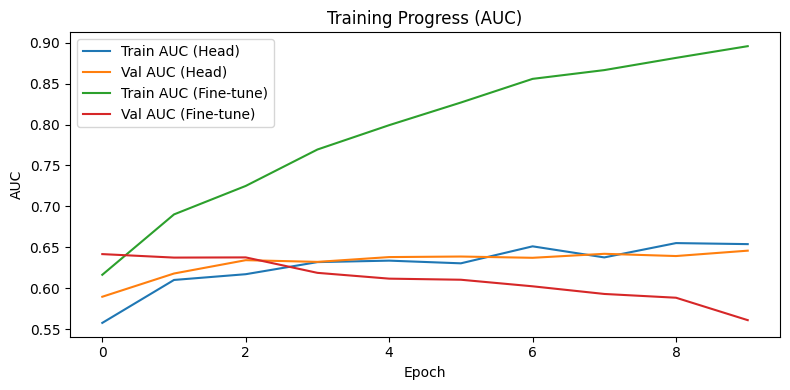

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
print("\n🚀 Training Condition Classifier (ResNet50)")

# ===== CONDITION CLASSIFIER (ResNet50) =====

# --- Use only Good Quality images ---
good_quality_classes = ["Good Foot Picture"]
df_good = df_iqa[df_iqa["clean_image_quality_simple"].isin(good_quality_classes)].copy()

# --- Filter invalid or empty label lists ---
df_good = df_good[df_good["labels"].apply(lambda x: isinstance(x, list) and len(x) > 0)]
print(f"🧩 After filtering, {len(df_good)} images remain with valid condition labels.")

# --- Drop very rare labels ---
all_labels = [l for sub in df_good["labels"] for l in sub]
label_counts = Counter(all_labels)
valid_labels = [l for l, c in label_counts.items() if c >= 20]
df_good["labels"] = df_good["labels"].apply(lambda lst: [x for x in lst if x in valid_labels])
df_good = df_good[df_good["labels"].map(len) > 0]
print(f"✅ Using {len(valid_labels)} condition classes: {valid_labels}")

# --- Prepare data ---
X_cond = df_good["cleaned_path"].values
y_cond = df_good["labels"]

mlb = MultiLabelBinarizer()
y_cond_bin = mlb.fit_transform(y_cond)

# --- Split ---
X_train, X_val, y_train, y_val = train_test_split(
    X_cond, y_cond_bin, test_size=0.2, random_state=42
)
print(f"✅ Dataset: {len(X_train)} train / {len(X_val)} val")


# --- Data Pipeline ---

def preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(512).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)


# --- Model Definition ---

base_model_cond = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model_cond.trainable = False

x = layers.GlobalAveragePooling2D()(base_model_cond.output)
x = layers.Dropout(0.4)(x)
output = layers.Dense(len(mlb.classes_), activation="sigmoid")(x)
cond_model = models.Model(inputs=base_model_cond.input, outputs=output)

cond_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)

print(cond_model.summary())


# --- Stage 1: Train Head ---

history_cond = cond_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


# --- Stage 2: Fine-Tune ResNet ---

print("\n🔧 Fine-tuning ResNet last 50 layers...")
base_model_cond.trainable = True
for layer in base_model_cond.layers[:-50]:
    layer.trainable = False

cond_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)

fine_tune_history = cond_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


# --- Evaluation --- 

val_loss, val_auc = cond_model.evaluate(val_ds)
print(f"✅ Final Validation AUC: {val_auc:.3f}")


# --- Save ---

cond_model.save("condition_classifier_resnet50.keras")
print("💾 Saved model (modern .keras format)")


# --- Plot Training Curves ---

plt.figure(figsize=(8,4))
plt.plot(history_cond.history["auc"], label="Train AUC (Head)")
plt.plot(history_cond.history["val_auc"], label="Val AUC (Head)")
plt.plot(fine_tune_history.history["auc"], label="Train AUC (Fine-tune)")
plt.plot(fine_tune_history.history["val_auc"], label="Val AUC (Fine-tune)")
plt.title("Training Progress (AUC)")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.tight_layout()
plt.show()

Columns in CSV: ['annotation_id', 'annotator', 'created_at', 'foot_conditions', 'id', 'image', 'image_quality', 'lead_time', 'updated_at']
CSV rows: 1490
Resolved 740 / 1490 CSV paths → local files.

Using 10 condition classes:
['Callus', 'Red spots on feet', 'Wound on foot', 'Red spots that increase with shoes', 'Red, thick, swollen foot', 'Normal Foot', 'Blue discoloration under nail', 'Callus with dark discoloration', 'Other abnormal discoloration', 'Soft skin between toes (white)']
621 images remain after filtering
Classes: ['Blue discoloration under nail', 'Callus', 'Callus with dark discoloration', 'Normal Foot', 'Other abnormal discoloration', 'Red spots on feet', 'Red spots that increase with shoes', 'Red, thick, swollen foot', 'Soft skin between toes (white)', 'Wound on foot']
Dataset: 496 train / 125 val


Model: "EffNetB3_multilabel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          15,370 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,798,905 (41.19 MB)

 Trainable params: 15,370 (60.04 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

Epoch 1/8
31/31 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - auc: 0.5615 - loss: 0.5369 - val_auc: 0.6881 - val_loss: 0.3645 - learning_rate: 0.0010
Epoch 2/8
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - auc: 0.7322 - loss: 0.3570 - val_auc: 0.7433 - val_loss: 0.3453 - learning_rate: 0.0010
Epoch 3/8
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - auc: 0.7835 - loss: 0.3357 - val_auc: 0.7531 - val_loss: 0.3385 - learning_rate: 0.0010
Epoch 4/8
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - auc: 0.7839 - loss: 0.3221 - val_auc: 0.7602 - val_loss: 0.3355 - learning_rate: 0.0010
Epoch 5/8
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - auc: 0.8244 - loss: 0.3072 - val_auc: 0.7725 - val_loss: 0.3281 - learning_rate: 0.0010
Epoch 6/8
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - auc: 0.8477 - loss: 0.2852 - val_auc: 0.7767 - val_loss: 0.3263 - learning_rate: 0.0010
Epoch 7/8
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - auc: 0.8494 - loss: 0.2909 - val_auc: 0.7816 - val_loss: 0.3245 - learning_rate: 0.0010
Epoch 8/8
31/31 ━━━━━━━━━━━

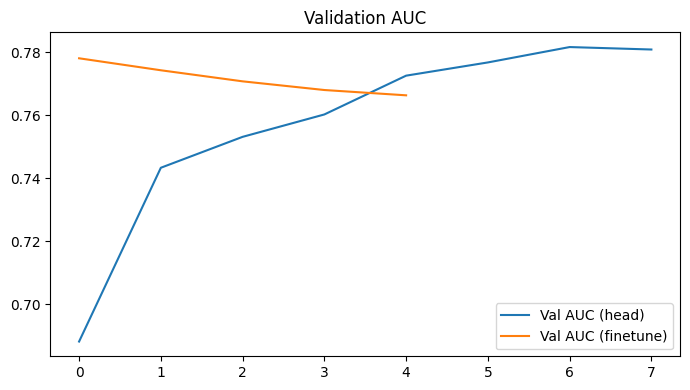


🔬 Demo prediction on: D:\shanessa\SHANESSSA_AI_dm_zelfcheck\extracted_pictures\scaled_36a7520c-596e-4af6-94c5-6d08ba6cff548210503504801326928.JPEG
  Wound on foot                             p=0.620
  Callus with dark discoloration            p=0.396
  Callus                                    p=0.390
  Red spots on feet                         p=0.127
  Red, thick, swollen foot                  p=0.096


In [23]:
import os
import re
import ast
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# ===== End-to-end MULTILABEL training with tf.data (no dtype object errors) =====

# --- Repro & mixed precision (optional) ---

tf.random.set_seed(42)
np.random.seed(42)
# Comment out mixed precision because GPU/TensorFlow build is picky
# tf.keras.mixed_precision.set_global_policy("mixed_float16")


# --- Paths (EDIT if needed) ---

CSV_PATH = r"C:\Users\shanessa\Downloads\labels.csv"
IMAGE_BASE_PATH = r"D:\shanessa\SHANESSSA_AI_dm_zelfcheck\extracted_pictures"


# --- Load CSV ---

df = pd.read_csv(CSV_PATH)
assert "image" in df.columns, "CSV must contain an 'image' column."
print("Columns in CSV:", df.columns.tolist())
print("CSV rows:", len(df))


# --- Index local files & resolve CSV paths to local --- 

ALLOWED_EXTS = {".jpeg", ".jpg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def gen_keys(basename: str):
    b = str(basename).strip().lower()
    stem, _ = os.path.splitext(b)
    keys = {b, stem, f"scaled_{b}", f"scaled_{stem}"}
    m = re.search(r"(image_picker_.*)", b)
    if m:
        tail = m.group(1)
        tstem, _ = os.path.splitext(tail)
        keys.update({tail, tstem, f"scaled_{tail}", f"scaled_{tstem}"})
        m2 = re.search(r"image_picker_(.*)", b)
        if m2:
            pure = m2.group(1)
            pstem, _ = os.path.splitext(pure)
            keys.update({pure, pstem, f"scaled_{pure}", f"scaled_{pstem}"})
    return keys

local_files = []
for root, _, files in os.walk(IMAGE_BASE_PATH):
    for f in files:
        if os.path.splitext(f)[1].lower() in ALLOWED_EXTS:
            local_files.append(os.path.join(root, f))

if not local_files:
    raise RuntimeError(f"No images found under {IMAGE_BASE_PATH}")

index = {}
for fp in local_files:
    base = os.path.basename(fp)
    for k in gen_keys(base):
        index.setdefault(k, fp)

def resolve_csv_path(csv_path: str):
    if pd.isna(csv_path):
        return None
    basename = os.path.basename(str(csv_path))
    for k in gen_keys(basename):
        if k in index:
            return index[k]
    return None

df["resolved_path"] = df["image"].apply(resolve_csv_path)
found = df["resolved_path"].notna().sum()
print(f"Resolved {found} / {len(df)} CSV paths → local files.")
if found == 0:
    raise SystemExit("No images could be resolved — stop here to fix paths.")


# --- Parse multi-label "foot_conditions" ---

def parse_foot_conditions(val):
    if pd.isna(val):
        return []
    try:
        parsed = ast.literal_eval(val)
        if isinstance(parsed, dict) and "choices" in parsed:
            return parsed["choices"]
        elif isinstance(parsed, list):
            return parsed
        else:
            return [str(parsed)]
    except Exception:
        return [str(val)]

df["labels"] = df.get("foot_conditions", pd.Series([""] * len(df))).apply(parse_foot_conditions)

# keep only rows with resolved image
df = df[df["resolved_path"].notna()].reset_index(drop=True)


# --- Drop rare labels (min count per class) ---

MIN_PER_CLASS = 5
all_labels = [lab for sub in df["labels"] for lab in sub]
label_counts = Counter(all_labels)
valid_labels = [l for l, c in label_counts.items() if c >= MIN_PER_CLASS]

df["labels"] = df["labels"].apply(lambda lst: [x for x in lst if x in valid_labels])
df = df[df["labels"].map(len) > 0].reset_index(drop=True)

print(f"\nUsing {len(valid_labels)} condition classes:\n{valid_labels}")
print(f"{len(df)} images remain after filtering")


# --- Binarize labels ---

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df["labels"])
X = df["resolved_path"].astype(str).values

NUM_CLASSES = len(mlb.classes_)
print("Classes:", list(mlb.classes_))


# --- Train/Val split (random; multilabel stratify is non-trivial) ---

X_train, X_val, y_train, y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)
print(f"Dataset: {len(X_train)} train / {len(X_val)} val")


# --- tf.data pipeline (fixes object dtype issues) ---

IMG_SIZE = (300, 300)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# convert to tf dtypes
y_train = y_train.astype("float32")
y_val   = y_val.astype("float32")

def load_image(path, label):
    img = tf.io.read_file(path)
    # decode jpg/png/etc.
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    # EfficientNet expects preprocess_input
    img = preprocess_input(img)  # handles scaling to [-1,1]
    return img, label

data_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.1),
], name="augment")

def add_aug(img, label):
    return data_augment(img, training=True), label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1024, seed=42, reshuffle_each_iteration=True)
train_ds = train_ds.map(load_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(add_aug, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


# --- Model (EfficientNetB3 head) ---

base = EfficientNetB3(weights="imagenet", include_top=False,
                      input_shape=(*IMG_SIZE, 3), pooling="avg")
base.trainable = False  # head only first

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation="sigmoid", dtype="float32")(x)

model = keras.Model(inputs, outputs, name="EffNetB3_multilabel")

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="auc")]
)

model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, verbose=1),
    keras.callbacks.ModelCheckpoint(
        "condition_cls_head.keras",
        monitor="val_auc",
        mode="max",
        save_best_only=True
    )
]

EPOCHS_HEAD = 8
hist_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks
)


# --- Fine-tune top layers ---

print("\n🔧 Fine-tuning top layers...")
base.trainable = True
# freeze all but last 50 layers
for layer in base.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="auc")]
)

callbacks_ft = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, verbose=1),
    keras.callbacks.ModelCheckpoint(
        "condition_cls_finetune.keras",
        monitor="val_auc",
        mode="max",
        save_best_only=True
    )
]

EPOCHS_FT = 10
hist_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FT,
    callbacks=callbacks_ft
)


# --- Evaluate & Save (modern format) ---

val_loss, val_auc = model.evaluate(val_ds)
print(f"✅ Final Validation AUC: {val_auc:.3f}")

MODEL_OUT_PATH = "condition_classifier_efficientnetb3.keras"
model.save(MODEL_OUT_PATH)
print(f"💾 Saved model: {MODEL_OUT_PATH}")


# --- Save the MultiLabelBinarizer for export to TF.js ---

import pickle

BINARIZER_OUT_PATH = "condition_label_binarizer.pkl"
with open(BINARIZER_OUT_PATH, "wb") as f:
    pickle.dump(mlb, f)

print(f"💾 Saved label binarizer: {BINARIZER_OUT_PATH}")


# --- Curves ---

plt.figure(figsize=(7, 4))
plt.plot(hist_head.history["val_auc"], label="Val AUC (head)")
plt.plot(hist_ft.history["val_auc"], label="Val AUC (finetune)")
plt.legend()
plt.title("Validation AUC")
plt.tight_layout()
plt.show()


# --- Demo prediction on a non-training image (if available) ---

# Try to pick a local file not used in X_train/X_val
all_used = set(list(X_train) + list(X_val))
candidate = None
for p in local_files:
    if p not in all_used:
        candidate = p
        break

if candidate is None and len(X_val) > 0:
    candidate = X_val[0]  # fallback: reuse a val image

def predict_one(img_path, model, mlb, top_k=5, threshold=0.5):
    img_bytes = tf.io.read_file(img_path)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    probs = model.predict(tf.expand_dims(img, 0), verbose=0)[0]
    # Show top-k labels
    idxs = np.argsort(probs)[::-1][:top_k]
    return [(mlb.classes_[i], float(probs[i])) for i in idxs], probs >= threshold

if candidate:
    topk, bin_pred = predict_one(candidate, model, mlb, top_k=5, threshold=0.5)
    print("\n🔬 Demo prediction on:", candidate)
    for lbl, p in topk:
        print(f"  {lbl:40s}  p={p:.3f}")

In [15]:
import pickle

with open("label_binarizer.pkl", "wb") as f:
    pickle.dump(mlb, f)

print("✅ Saved label binarizer with classes:", mlb.classes_)


✅ Saved label binarizer with classes: ['Blue discoloration under nail' 'Callus' 'Callus with dark discoloration'
 'Normal Foot' 'Other abnormal discoloration' 'Red spots on feet'
 'Red spots that increase with shoes' 'Red, thick, swollen foot'
 'Soft skin between toes (white)' 'Wound on foot']


🔄 Loading model and label encoder...
✅ Model and 10 class labels loaded.

🔍 Predictions for: D:\shanessa\SHANESSSA_AI_dm_zelfcheck\extracted_pictures\image_picker_02DD8296-43FD-44DE-85CA-8FE705594D9D-41429-0000139C7B4DB464.JPEG
Top predictions:
  Wound on foot                            p=0.624
  Callus with dark discoloration           p=0.353
  Callus                                   p=0.317
  Normal Foot                              p=0.211
  Red spots on feet                        p=0.167

✅ Labels above threshold (p ≥ 0.5):
  Wound on foot                            p=0.624


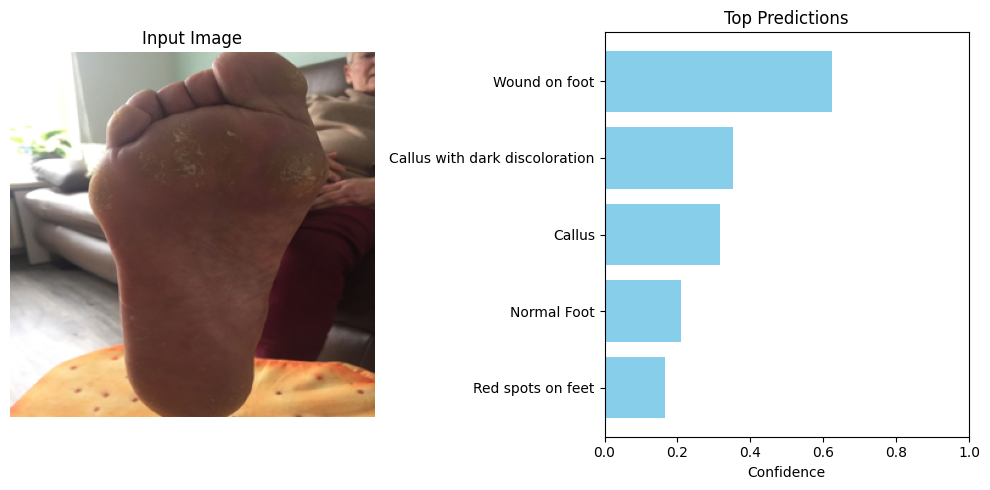

In [16]:
import sys

# --- CONFIG ---

MODEL_PATH = "condition_classifier_efficientnetb3.keras"
LABEL_BINARIZER_PATH = "label_binarizer.pkl"
IMG_SIZE = (300, 300)
TOP_K = 5
THRESHOLD = 0.5  # show all classes > 0.5


# --- LOAD MODEL + LABELS ---

print("🔄 Loading model and label encoder...")
model = keras.models.load_model(MODEL_PATH)

with open(LABEL_BINARIZER_PATH, "rb") as f:
    mlb = pickle.load(f)

class_names = mlb.classes_.tolist()
print(f"✅ Model and {len(class_names)} class labels loaded.")


# --- IMAGE PREPROCESSING ---

def preprocess_image(image_path):
    """Load, resize, and normalize an image for EfficientNet."""
    img = Image.open(image_path).convert("RGB")
    img = img.resize(IMG_SIZE)
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0), img


# --- PREDICT FUNCTION ---

def predict_image(image_path, show_image=True):
    """Run prediction and optionally display the image."""
    img_tensor, img_show = preprocess_image(image_path)
    preds = model.predict(img_tensor, verbose=0)[0]

    # Sort predictions
    sorted_idxs = np.argsort(preds)[::-1]
    results = [(class_names[i], float(preds[i])) for i in sorted_idxs[:TOP_K]]
    above_thresh = [(class_names[i], float(preds[i])) for i in range(len(preds)) if preds[i] >= THRESHOLD]

    # Print textual results
    print("\n🔍 Predictions for:", image_path)
    print("Top predictions:")
    for cls, prob in results:
        print(f"  {cls:40s} p={prob:.3f}")

    if above_thresh:
        print("\n✅ Labels above threshold (p ≥ 0.5):")
        for cls, prob in above_thresh:
            print(f"  {cls:40s} p={prob:.3f}")
    else:
        print("\n⚠️ No class above threshold (all < 0.5)")

    # Optional: Display image + bar chart
    if show_image:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img_show)
        ax[0].axis("off")
        ax[0].set_title("Input Image")

        labels, probs = zip(*results)
        ax[1].barh(labels[::-1], probs[::-1], color="skyblue")
        ax[1].set_xlim(0, 1)
        ax[1].set_xlabel("Confidence")
        ax[1].set_title("Top Predictions")
        plt.tight_layout()
        plt.show()

    return results


# --- MAIN ---

if __name__ == "__main__":
    # Jupyter sometimes passes -f flags; ignore them
    args = [a for a in sys.argv[1:] if not a.startswith("-")]

    # 👇 Hardcode or pass an image path here
    image_path = r"D:\shanessa\SHANESSSA_AI_dm_zelfcheck\extracted_pictures\image_picker_02DD8296-43FD-44DE-85CA-8FE705594D9D-41429-0000139C7B4DB464.JPEG"

    if not os.path.exists(image_path):
        print("❌ File not found:", image_path)
        sys.exit(1)

    predict_image(image_path)



🔍 Predictions for: C:\Users\shanessa\Downloads\test.jpeg
Top predictions:
  Normal Foot                              p=0.388
  Red, thick, swollen foot                 p=0.365
  Blue discoloration under nail            p=0.332
  Red spots on feet                        p=0.330
  Wound on foot                            p=0.195

⚠️ No class above threshold (all < 0.5)


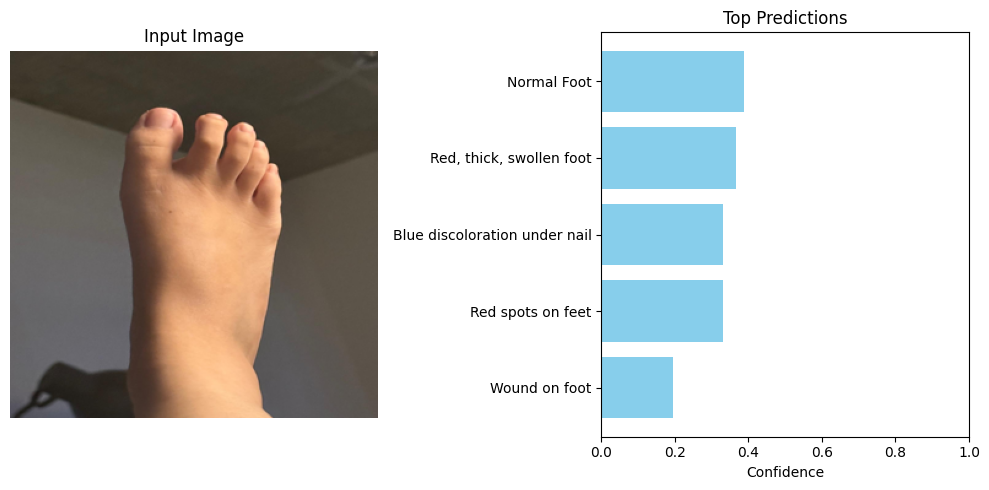

In [17]:

# --- MAIN ---

if __name__ == "__main__":
    # Jupyter sometimes passes -f flags; ignore them
    args = [a for a in sys.argv[1:] if not a.startswith("-")]

    # 👇 Hardcode or pass an image path here
    image_path = r"C:\Users\shanessa\Downloads\test.jpeg"

    if not os.path.exists(image_path):
        print("❌ File not found:", image_path)
        sys.exit(1)

    predict_image(image_path)


In [18]:
import pickle
import numpy as np

# --- Save Model and LabelEncoder ---
MODEL_QUALITY_PATH = "image_quality_efficientnetb0.keras"
ENCODER_QUALITY_PATH = "label_encoder_quality.pkl"

# Save the final trained model
model.save(MODEL_QUALITY_PATH)
print(f"💾 Saved Image Quality Model: {MODEL_QUALITY_PATH}")

# Save the LabelEncoder
with open(ENCODER_QUALITY_PATH, "wb") as f:
    pickle.dump(le, f)
print(f"✅ Saved LabelEncoder for quality classes: {le.classes_}")

💾 Saved Image Quality Model: image_quality_efficientnetb0.keras
✅ Saved LabelEncoder for quality classes: ['Bad Angle / Foot not fully visible' 'Blurry (out of focus)'
 'Good Foot Picture' 'Not a Foot' 'Too Dark (Underexposed)'
 'Too Far (Foot too small in frame)']


🔄 Loading CORRECT Image Quality model and label encoder...
✅ IQA Model and 6 class labels loaded.

🔍 Image Quality Predictions for: C:\Users\shanessa\Downloads\20250918_1640_Ghibli Style Transformation_remix_01k5em5ynfex3sf0jxy81rksx7.png
Top predictions:
  Not a Foot                               p=0.684
  Blurry (out of focus)                    p=0.098
  Too Dark (Underexposed)                  p=0.079
  Bad Angle / Foot not fully visible       p=0.068
  Too Far (Foot too small in frame)        p=0.043


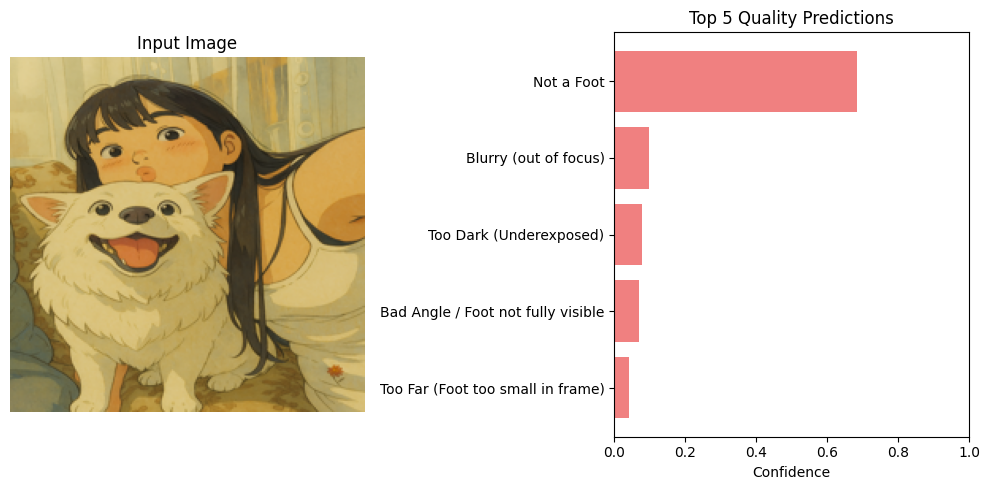

In [19]:
import sys
import numpy as np
import pickle
import os
from PIL import Image
from tensorflow import keras
import matplotlib.pyplot as plt

# 💡 Import the *correct* preprocessing function
from tensorflow.keras.applications.efficientnet import preprocess_input 

# --- CONFIGURATION ---
# 💡 Point to the model and encoder from your "Optimized" script
MODEL_IQA_PATH = "foot_quality_best.keras" 
ENCODER_IQA_PATH = "foot_quality_label_encoder.pkl"
IMG_SIZE = (224, 224) # Must match the IMG_SIZE from that training script
TOP_K = 5

# --- LOAD MODEL + LABELS ---
print("🔄 Loading CORRECT Image Quality model and label encoder...")
try:
    model_iqa = keras.models.load_model(MODEL_IQA_PATH)
    with open(ENCODER_IQA_PATH, "rb") as f:
        le_iqa = pickle.load(f)
except Exception as e:
    print(f"❌ Could not load model/encoder. Make sure 'foot_quality_best.keras' and 'foot_quality_label_encoder.pkl' exist. Error: {e}")
    sys.exit(1)

iqa_class_names = le_iqa.classes_.tolist()
print(f"✅ IQA Model and {len(iqa_class_names)} class labels loaded.")


# --- IMAGE PREPROCESSING (CORRECTED) ---
def preprocess_image_iqa(image_path):
    """Load, resize, and normalize using the *correct* EfficientNet function."""
    img = Image.open(image_path).convert("RGB")
    img = img.resize(IMG_SIZE)
    img_array = np.array(img, dtype=np.float32)
    
    # 💡 This function scales to [-1, 1] and matches the training
    img_array = preprocess_input(img_array) 
    
    return np.expand_dims(img_array, axis=0), img

# --- PREDICT FUNCTION ---
def predict_image_iqa(image_path, show_image=True):
    """Run prediction for image quality and display results."""
    img_tensor, img_show = preprocess_image_iqa(image_path)
    # Model predicts probabilities for each class
    probs = model_iqa.predict(img_tensor, verbose=0)[0] 

    # Find the top K predictions
    sorted_idxs = np.argsort(probs)[::-1]
    results = [(iqa_class_names[i], float(probs[i])) for i in sorted_idxs[:TOP_K]]
    
    # Print results
    print("\n🔍 Image Quality Predictions for:", image_path)
    print("Top predictions:")
    for cls, prob in results:
        print(f"  {cls:40s} p={prob:.3f}")
    
    # Optional: Display image + bar chart
    if show_image:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img_show)
        ax[0].axis("off")
        ax[0].set_title("Input Image")

        labels, probs_val = zip(*results)
        ax[1].barh(labels[::-1], probs_val[::-1], color="lightcoral")
        ax[1].set_xlim(0, 1)
        ax[1].set_xlabel("Confidence")
        ax[1].set_title(f"Top {TOP_K} Quality Predictions")
        plt.tight_layout()
        plt.show()

    return results

# --- MAIN TEST EXECUTION ---
if __name__ == "__main__":
    # 👇 Use a test image path here
    test_image_path = r"C:\Users\shanessa\Downloads\20250918_1640_Ghibli Style Transformation_remix_01k5em5ynfex3sf0jxy81rksx7.png"
    
    if not os.path.exists(test_image_path):
        print(f"❌ Test image not found at: {test_image_path}")
        sys.exit(1)
        
    predict_image_iqa(test_image_path)

🔄 Loading model and label encoder...
✅ Loaded 6 label classes.

🔍 Comparing Trained IQA Model vs OpenCV Metrics
Image: C:\Users\shanessa\Downloads\20250918_1640_Ghibli Style Transformation_remix_01k5em5ynfex3sf0jxy81rksx7.png

📌 Trained Model Predictions (Top-K):
   Not a Foot                          p=0.684
   Blurry (out of focus)               p=0.098
   Too Dark (Underexposed)             p=0.079
   Bad Angle / Foot not fully visible  p=0.068
   Too Far (Foot too small in frame)   p=0.043

📌 OpenCV Measured Quality Scores:
   Sharpness_Laplacian      : 1367.524
   Contrast_STD             : 46.507
   Brightness               : 145.822
   NoiseVariance            : 15095.935
   Blockiness               : 242.208


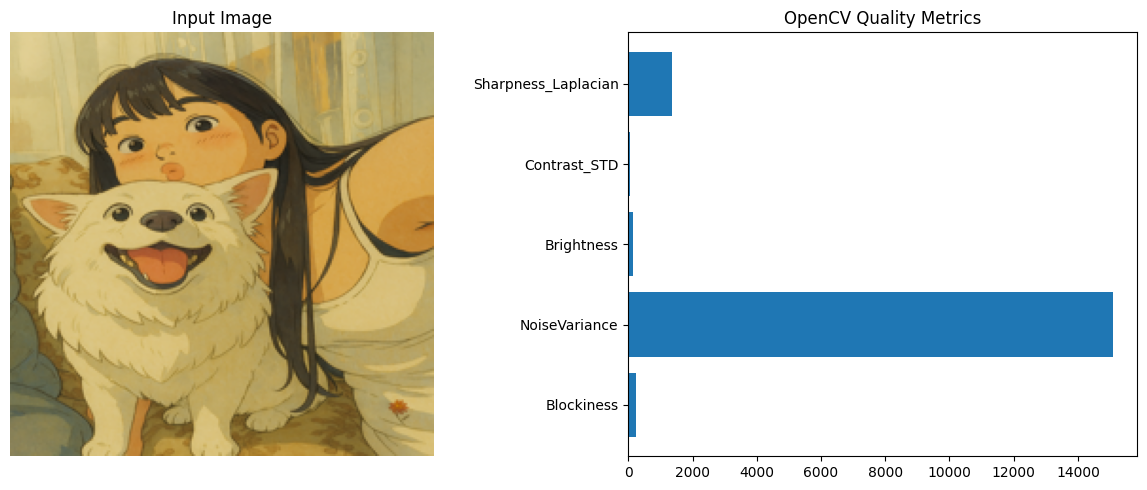

In [20]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import os
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import preprocess_input

# ============================================================
# CONFIG
# ============================================================
MODEL_PATH = "foot_quality_best.keras"
ENCODER_PATH = "foot_quality_label_encoder.pkl"
IMG_SIZE = (224, 224)
TOP_K = 5

# ============================================================
# LOAD MODEL + ENCODER
# ============================================================
print("🔄 Loading model and label encoder...")
model = keras.models.load_model(MODEL_PATH)

with open(ENCODER_PATH, "rb") as f:
    label_encoder = pickle.load(f)

class_names = label_encoder.classes_.tolist()
print(f"✅ Loaded {len(class_names)} label classes.")


# ============================================================
# YOUR MODEL PREDICTION
# ============================================================
def preprocess_image_efficientnet(path):
    img = Image.open(path).convert("RGB")
    img = img.resize(IMG_SIZE)
    arr = np.array(img, dtype=np.float32)
    arr = preprocess_input(arr)
    return np.expand_dims(arr, axis=0), img


def predict_trained_model(path):
    img_tensor, img_raw = preprocess_image_efficientnet(path)
    preds = model.predict(img_tensor, verbose=0)[0]
    sorted_idx = np.argsort(preds)[::-1]

    results = [(class_names[i], float(preds[i])) for i in sorted_idx[:TOP_K]]
    
    return results, img_raw


# ============================================================
# OPENCV QUALITY METRICS
# ============================================================
def compute_opencv_metrics(path):
    img = cv2.imread(path)

    if img is None:
        raise ValueError("Image cannot be read by OpenCV.")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # --- 1. Sharpness (Variance of Laplacian)
    sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()

    # --- 2. Contrast (std of pixel intensities)
    contrast = np.std(gray)

    # --- 3. Brightness (mean of grayscale)
    brightness = np.mean(gray)

    # --- 4. Noise Estimate (var of high-pass filtered image)
    noise = cv2.GaussianBlur(gray, (3, 3), 0)
    noise = np.var(gray - noise)

    # --- 5. JPEG Compression Quality Estimation (simple blockiness metric)
    def blockiness_score(gray_img):
        h, w = gray_img.shape
        vertical_diff = np.sum(np.abs(gray_img[:, 1:] - gray_img[:, :-1]))
        horizontal_diff = np.sum(np.abs(gray_img[1:, :] - gray_img[:-1, :]))
        return (vertical_diff + horizontal_diff) / (h * w)

    blockiness = blockiness_score(gray)

    return {
        "Sharpness_Laplacian": sharpness,
        "Contrast_STD": contrast,
        "Brightness": brightness,
        "NoiseVariance": noise,
        "Blockiness": blockiness
    }


# ============================================================
# FULL COMPARISON FUNCTION
# ============================================================
def compare_quality(path, show_plots=True):
    print("\n======================================================")
    print("🔍 Comparing Trained IQA Model vs OpenCV Metrics")
    print("======================================================")
    print(f"Image: {path}\n")

    # ---- Model prediction ----
    model_results, img_raw = predict_trained_model(path)

    print("📌 Trained Model Predictions (Top-K):")
    for cls, prob in model_results:
        print(f"   {cls:35s} p={prob:.3f}")

    # ---- OpenCV metrics ----
    metrics = compute_opencv_metrics(path)

    print("\n📌 OpenCV Measured Quality Scores:")
    for k, v in metrics.items():
        print(f"   {k:25s}: {v:.3f}")

    # ---- Graphs ----
    if show_plots:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # Show image
        ax[0].imshow(img_raw)
        ax[0].axis("off")
        ax[0].set_title("Input Image")

        # Bar chart for OpenCV metrics
        keys = list(metrics.keys())
        vals = list(metrics.values())
        ax[1].barh(keys[::-1], vals[::-1])
        ax[1].set_title("OpenCV Quality Metrics")
        plt.tight_layout()
        plt.show()

    return model_results, metrics


# ============================================================
# MAIN TEST
# ============================================================
if __name__ == "__main__":
    test_image = r"C:\Users\shanessa\Downloads\20250918_1640_Ghibli Style Transformation_remix_01k5em5ynfex3sf0jxy81rksx7.png"

    if not os.path.exists(test_image):
        print("❌ Test image not found.")
        exit()

    compare_quality(test_image)


In [28]:
import sys
import types
import os
import json
import pickle
import shutil
import tensorflow as tf
from tensorflow.keras.models import load_model

# ============================================================
# 🚑 PRE-FLIGHT PATCH (CRITICAL)
# We trick the CURRENT process into thinking TF-DF is installed.
# ============================================================
try:
    mock_tfdf = types.ModuleType("tensorflow_decision_forests")
    sys.modules["tensorflow_decision_forests"] = mock_tfdf
    mock_tfdf.keras = types.ModuleType("tensorflow_decision_forests.keras")
    sys.modules["tensorflow_decision_forests.keras"] = mock_tfdf.keras
    print("✅ Successfully patched tensorflow_decision_forests dependency.")
except Exception as e:
    print(f"⚠️ Patch warning: {e}")

# Import TFJS *AFTER* the patch
import tensorflowjs as tfjs
from tensorflowjs.converters import tf_saved_model_conversion_v2

# ============================================================
# CONFIGURATION
# ============================================================

IQA_MODEL_IN = "foot_quality_best.keras"
IQA_ENCODER_IN = "foot_quality_label_encoder.pkl"

CONDITION_MODEL_IN = "condition_classifier_efficientnetb3.keras"
CONDITION_BINARIZER_IN = "condition_label_binarizer.pkl"

EXPORT_DIR = "./tfjs_export"
IQA_MODEL_OUT_DIR = os.path.join(EXPORT_DIR, "iqa_model")
CONDITION_MODEL_OUT_DIR = os.path.join(EXPORT_DIR, "condition_model")
IQA_LABELS_OUT = os.path.join(EXPORT_DIR, "iqa_labels.json")
CONDITION_LABELS_OUT = os.path.join(EXPORT_DIR, "condition_labels.json")

# ============================================================
# CONVERSION LOGIC
# ============================================================

def convert_in_process(keras_path, output_dir):
    """
    Converts Keras -> SavedModel -> TFJS completely in memory/process.
    No subprocess calls. No pickle errors.
    """
    temp_dir = f"temp_{os.path.basename(keras_path).split('.')[0]}"
    
    print(f"\n🔄 Processing: {keras_path}")
    
    # Clean up previous temp runs
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
        
    try:
        # 1. Load Keras Model
        print("   Loading Keras model...")
        model = load_model(keras_path)
        
        # 2. Export to native SavedModel (Folders)
        # This bypasses the pickle/HDF5 issue
        print(f"   Exporting to intermediate SavedModel: {temp_dir}...")
        model.export(temp_dir) 
        
        # 3. Convert using Internal API (In-Process)
        # This bypasses the subprocess/ModuleNotFoundError issue
        print("   Converting to TF.js (In-Process)...")
        
        # This function is what the CLI calls internally. We call it directly.
        tf_saved_model_conversion_v2.convert_tf_saved_model(
            saved_model_dir=temp_dir,
            output_dir=output_dir,
            signature_def="serving_default",
            saved_model_tags="serve",
            output_format="tfjs_graph_model", # Graph model is safer for EfficientNet
            quantization_dtype_map=None,
            skip_op_check=True,
            strip_debug_ops=True,
            weight_shard_size_bytes=4194304 # 4MB shards
        )

        print(f"✅ Successfully saved to: {output_dir}")

    except Exception as e:
        print(f"❌ Error converting {keras_path}:")
        import traceback
        traceback.print_exc()
    finally:
        # Cleanup
        if os.path.exists(temp_dir):
            print("   Cleaning up temp files...")
            shutil.rmtree(temp_dir)

def export_labels(pkl_path, json_path):
    try:
        with open(pkl_path, "rb") as f:
            encoder = pickle.load(f)
        
        if hasattr(encoder, 'classes_'):
            labels = encoder.classes_.tolist()
        else:
            labels = list(encoder)
            
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        with open(json_path, "w") as f:
            json.dump(labels, f, indent=2)
        print(f"✅ Labels exported: {json_path}")
    except Exception as e:
        print(f"❌ Label export failed: {e}")

# ============================================================
# MAIN
# ============================================================

def main():
    # Validate files
    files = [IQA_MODEL_IN, IQA_ENCODER_IN, CONDITION_MODEL_IN, CONDITION_BINARIZER_IN]
    missing = [f for f in files if not os.path.exists(f)]
    if missing:
        print(f"❌ Missing files: {missing}")
        sys.exit(1)

    os.makedirs(IQA_MODEL_OUT_DIR, exist_ok=True)
    os.makedirs(CONDITION_MODEL_OUT_DIR, exist_ok=True)

    # Run Conversions
    convert_in_process(IQA_MODEL_IN, IQA_MODEL_OUT_DIR)
    export_labels(IQA_ENCODER_IN, IQA_LABELS_OUT)

    convert_in_process(CONDITION_MODEL_IN, CONDITION_MODEL_OUT_DIR)
    export_labels(CONDITION_BINARIZER_IN, CONDITION_LABELS_OUT)

    print("\n🎉 DONE. All files in ./tfjs_export")

if __name__ == "__main__":
    main()

✅ Successfully patched tensorflow_decision_forests dependency.

🔄 Processing: foot_quality_best.keras
   Loading Keras model...
   Exporting to intermediate SavedModel: temp_foot_quality_best...
INFO:tensorflow:Assets written to: temp_foot_quality_best\assets


INFO:tensorflow:Assets written to: temp_foot_quality_best\assets


Saved artifact at 'temp_foot_quality_best'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1624034399808: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1624034408432: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1624032836800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624032837328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624032826768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624032825888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624032827648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624032822544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624032824480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624032824656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  162403283

Traceback (most recent call last):
  File "C:\Users\shanessa\AppData\Local\Temp\ipykernel_18764\1538622610.py", line 75, in convert_in_process
    tf_saved_model_conversion_v2.convert_tf_saved_model(
TypeError: convert_tf_saved_model() got an unexpected keyword argument 'output_format'


   Exporting to intermediate SavedModel: temp_condition_classifier_efficientnetb3...
INFO:tensorflow:Assets written to: temp_condition_classifier_efficientnetb3\assets


INFO:tensorflow:Assets written to: temp_condition_classifier_efficientnetb3\assets


Saved artifact at 'temp_condition_classifier_efficientnetb3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='input_layer_10')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1624031807264: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1624305042176: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1624067440160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624067735968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624067741776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624067739488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624067740544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624067746880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624067744944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624067748640: TensorSpec(shape=(), dtype=tf.resource, na

Traceback (most recent call last):
  File "C:\Users\shanessa\AppData\Local\Temp\ipykernel_18764\1538622610.py", line 75, in convert_in_process
    tf_saved_model_conversion_v2.convert_tf_saved_model(
TypeError: convert_tf_saved_model() got an unexpected keyword argument 'output_format'
